# Choose whether to ignore warnings

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Load data

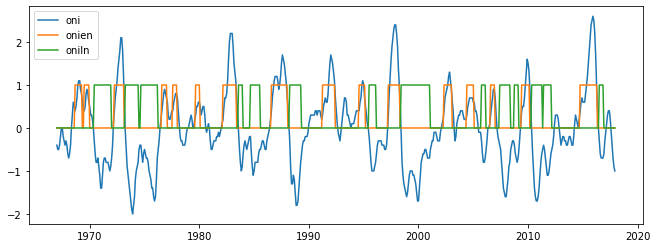

In [2]:
%run wcpfc_load_and_calc.ipynb

# Extra things to load

In [3]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import scipy.stats as stats

In [4]:
lon = wf['lon']
lat = wf['lat']

# Load WOD18 data

In [5]:
# Load o2, temp, sal from WOD18 nc files (already on good grid)
# -->Get SST, O2100, SSS
# -->Compute THD, TCD, O2100INT, T100INT

In [6]:
ncfile = dpath + 'WOD18/o2_195501-201807_5deg.nc'
o2 = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/sal_195501-201807_5deg.nc'
sal = xr.open_dataset(ncfile)
ncfile = dpath + 'WOD18/temp_195501-201807_5deg.nc'
temp = xr.open_dataset(ncfile)

### Correct the time axis

In [7]:
# - Time goes from Jan 1955 - Jul 2018 --> 763 months
begdatewod = datetime.date(year = 1955, month = 1, day = 1)
enddatewod = datetime.date(year = 2018, month = 7, day = 1)
timemowod = pd.date_range(begdatewod, enddatewod, freq='MS')

In [8]:
o2['time'] = timemowod
sal['time'] = timemowod
temp['time'] = timemowod

In [9]:
sst = temp['Temp'].isel(depth=0)
o2100 = o2['O2'].sel(depth=100)
sss = sal['Sal'].isel(depth=0)

### Change from -180-180 to 0-360 lon

In [10]:
# https://github.com/pydata/xarray/issues/577 - wrap 0 to 360
# https://github.com/pydata/xarray/issues/1875 - roll
sst['lon'] = np.mod(sst['lon'], 360)
sst = sst.reindex({'lon': np.sort(sst['lon'])}) # or: sst = sst.roll(lon=36)
o2100['lon'] = np.mod(o2100['lon'], 360)
o2100 = o2100.reindex({'lon': np.sort(o2100['lon'])}) # or: o2100 = o2100.roll(lon=36)
sss['lon'] = np.mod(sss['lon'], 360)
sss = sss.reindex({'lon': np.sort(sss['lon'])}) # or: sss = sss.roll(lon=36)

### Rename

In [11]:
sst.name = 'sst'
o2100.name = 'o2100'
sss.name = 'sss'

# Load chl data

In [97]:
ncfile = dpath + 'chl/ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_5degWCPFCgrid_GEO_PML_OCx-199709-201812-fv4.0.nc'
chl = xr.open_dataset(ncfile)

### Correct the time axis

In [98]:
# - Time goes from Sep 1997 - Dec 2018 --> 256 months
begdatechl = datetime.date(year = 1997, month = 9, day = 1)
enddatechl = datetime.date(year = 2018, month = 12, day = 1)
timemochl = pd.date_range(begdatechl, enddatechl, freq='MS')
chl['TIME'] = timemochl

### Rename

In [99]:
logchl = np.log10(chl['CHLA'])
logchl = logchl.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
logchl.name = 'logchl'

# Load MLD data

In [111]:
ncfile = dpath + 'ecco/MXLDEPTH.0001.WCPFC5deggrid.nc'
MLD = xr.open_dataset(ncfile)
mld = MLD['MLD']

### Correct the time axis

In [112]:
# - Time goes from Jan 1992 - Dec 2011 --> 240 months
begdatemld = datetime.date(year = 1992, month = 1, day = 1)
enddatemld = datetime.date(year = 2011, month = 12, day = 1)
timemomld = pd.date_range(begdatemld, enddatemld, freq='MS')
mld['TIME'] = timemomld

### Rename

In [113]:
mld = mld.rename({'LON':'lon', 'LAT':'lat', 'TIME':'time'})
mld.name = 'mld'

# Load SSHA data

In [16]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# ?Load wind speed or Lyapunov data

In [17]:
# (need to regrid to WCPFC grid OR use already matlab regridded files)

# Question 3abc from 9/19/19 in written lab notebook

In [18]:
def quotient_analysis(dfqa,binedges):
    # IV for indy var, DV for dep var
    dfqa['IV_bin']=pd.cut(dfqa['IV'],binedges)
    ivcounts=dfqa.groupby('IV_bin')['IV'].count()
    dvcounts=dfqa.groupby('IV_bin')['DV'].sum()
    ivfreq = ivcounts*100/ivcounts.sum()
    dvfreq = dvcounts*100/dvcounts.sum()
    dvquot = dvfreq/ivfreq
    return ivcounts, dvcounts, dvquot

In [19]:
def qafull(ivfull,dvfull,ivname,dvname,nbins,nruns):
    iv = ivfull.where(dvfull.notnull())
    dv = dvfull.where(ivfull.notnull())    
    
    ivminf = np.floor(10*iv.min())/10
    ivmaxc = np.ceil(10*iv.max())/10
    binedges = np.linspace(ivminf,ivmaxc,nbins+1)
            
    fig,axes = plt.subplots(figsize=(7,5),nrows=2,ncols=2)
    ivfull.plot.hist(ax=axes[0][0],bins=20); axes[0][0].set_title('IV - all values');
    iv.plot.hist(ax=axes[0][1],bins=20); axes[0][1].set_title('IV - assoc w/ DV values');
    dvfull.plot.hist(ax=axes[1][0],bins=20); axes[1][0].set_title('DV - all values');
    dv.plot.hist(ax=axes[1][1],bins=20); axes[1][1].set_title('DV - assoc w/ IV values');
    fig.tight_layout()
    
    dsqanow = xr.merge([iv, dv])
    dfqa = dsqanow.to_dataframe()
    dfqa.rename(columns={ivname: 'IV', dvname: 'DV'}, inplace=True)
    dfqa.reset_index(inplace=True)
    dfqa = dfqa.dropna(subset=['IV','DV'], how='any')

    ivcounts, dvcounts, dvquot = quotient_analysis(dfqa,binedges)

    # Bernal et al. 2007: replace=FALSE in the code, but in the paper it says replace=TRUE
    # --> I think I'll go w/ what the paper says?
    dfsimreplaceF = pd.DataFrame(); dfsimreplaceT = pd.DataFrame()
    for i in range(nruns):
        dfsimreplaceF=pd.concat([dfsimreplaceF,dfqa['DV'].sample(
            n=len(dfqa['DV']),replace=False).reset_index(
            drop=True)], axis=1).rename(columns={'DV':i})
        dfsimreplaceT=pd.concat([dfsimreplaceT,dfqa['DV'].sample(
            n=len(dfqa['DV']),replace=True).reset_index(
            drop=True)], axis=1).rename(columns={'DV':i})

    dfsimreplaceF = dfsimreplaceF.assign(IV=dfqa['IV'].values)
    dfsimreplaceT = dfsimreplaceT.assign(IV=dfqa['IV'].values)

    quotsimreplaceF = pd.DataFrame(); quotsimreplaceT = pd.DataFrame()
    for i in range(nruns):
        _,_,quotsimreplaceFtemp = quotient_analysis(
            dfsimreplaceF[[i,'IV']].rename(columns={i:'DV'}),binedges)
        quotsimreplaceF = pd.concat([quotsimreplaceF,quotsimreplaceFtemp], axis=1)
        _,_,quotsimreplaceTtemp = quotient_analysis(
            dfsimreplaceT[[i,'IV']].rename(columns={i:'DV'}),binedges)
        quotsimreplaceT = pd.concat([quotsimreplaceT,quotsimreplaceTtemp], axis=1)

    qlimsreplaceT = quotsimreplaceT.quantile([0.025, 0.975], axis=1)
    qlimsreplaceF = quotsimreplaceF.quantile([0.025, 0.975], axis=1)
    bincenters = (binedges[1:] + binedges[:-1])/2

    return dfqa['IV'], binedges, bincenters, ivcounts, dvcounts, dvquot, qlimsreplaceT, qlimsreplaceF

### SKJ CPUE x SST

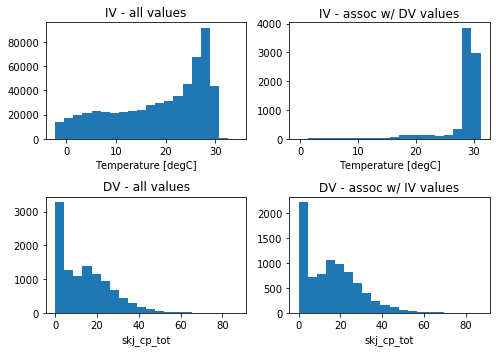

In [183]:
ivfull = sst; dvfull = skj_cp_tot
ivname = 'sst'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
#binedges = np.arange(-0.3,31.2+0.3,0.5) # sstnow.max() = 31.15, sstnow.min() = -0.28
iv_sstskjcp, binedges_sstskjcp, bincenters_sstskjcp, ivcounts_sstskjcp, \
    dvcounts_sstskjcp, dvquot_sstskjcp, qlimsreplaceT_sstskjcp, qlimsreplaceF_sstskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x O2100

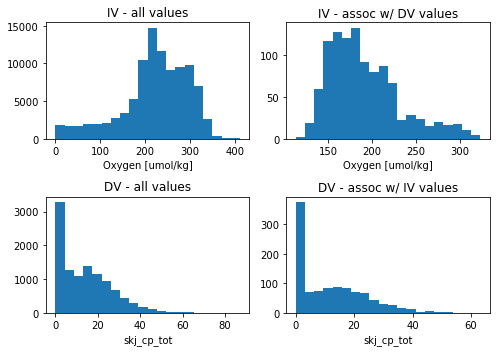

In [21]:
ivfull = o2100; dvfull = skj_cp_tot
ivname = 'o2100'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_o2100skjcp, binedges_o2100skjcp, bincenters_o2100skjcp, ivcounts_o2100skjcp, \
    dvcounts_o2100skjcp, dvquot_o2100skjcp, qlimsreplaceT_o2100skjcp, qlimsreplaceF_o2100skjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x SSS 

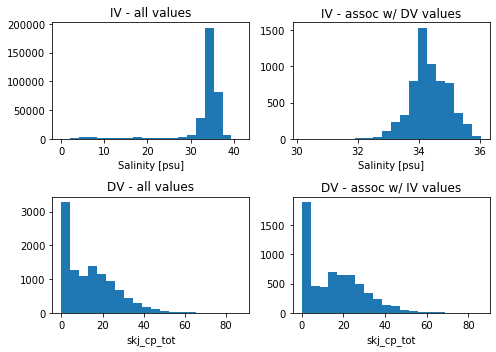

In [22]:
ivfull = sss; dvfull = skj_cp_tot
ivname = 'sss'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_sssskjcp, binedges_sssskjcp, bincenters_sssskjcp, ivcounts_sssskjcp, \
    dvcounts_sssskjcp, dvquot_sssskjcp, qlimsreplaceT_sssskjcp, qlimsreplaceF_sssskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x LOGCHL

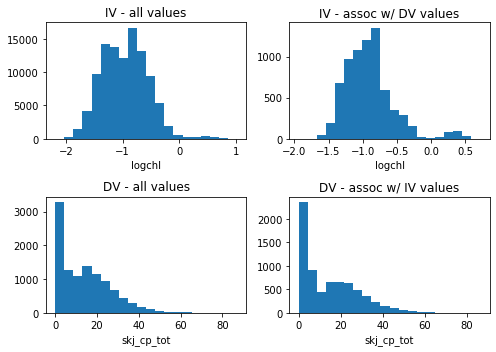

In [23]:
ivfull = logchl; dvfull = skj_cp_tot
ivname = 'logchl'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_logchlskjcp, binedges_logchlskjcp, bincenters_logchlskjcp, ivcounts_logchlskjcp, \
    dvcounts_logchlskjcp, dvquot_logchlskjcp, qlimsreplaceT_logchlskjcp, qlimsreplaceF_logchlskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE x MLD

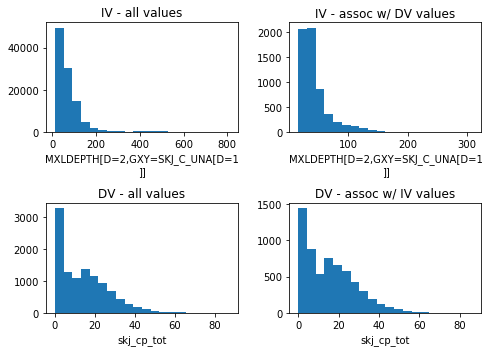

In [115]:
ivfull = mld; dvfull = skj_cp_tot
ivname = 'mld'; dvname = 'skj_cp_tot'
nruns = 399; nbins = 25
iv_mldskjcp, binedges_mldskjcp, bincenters_mldskjcp, ivcounts_mldskjcp, \
    dvcounts_mldskjcp, dvquot_mldskjcp, qlimsreplaceT_mldskjcp, qlimsreplaceF_mldskjcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### SKJ CPUE quotient analysis plot

In [116]:
ivunitsall = ['degC','umol/kg?','psu','log(mg/m$^3$)?','m']
ivnicenamesall = ['SST','O$2_{100m}$','SSS','log(CHL)','MLD']
dvnicenamesall = ['Skipjack CPUE','Skipjack CPUE','Skipjack CPUE','Skipjack CPUE','Skipjack CPUE']
ivall = [iv_sstskjcp, iv_o2100skjcp, iv_sssskjcp, iv_logchlskjcp, iv_mldskjcp]
binedgesall = [binedges_sstskjcp, binedges_o2100skjcp, binedges_sssskjcp, binedges_logchlskjcp, binedges_mldskjcp]
bincentersall = [bincenters_sstskjcp, bincenters_o2100skjcp, bincenters_sssskjcp, bincenters_logchlskjcp, bincenters_mldskjcp]
ivcountsall = [ivcounts_sstskjcp, ivcounts_o2100skjcp, ivcounts_sssskjcp, ivcounts_logchlskjcp, ivcounts_mldskjcp]
dvcountsall = [dvcounts_sstskjcp, dvcounts_o2100skjcp, dvcounts_sssskjcp, dvcounts_logchlskjcp, dvcounts_mldskjcp]
dvquotall = [dvquot_sstskjcp, dvquot_o2100skjcp, dvquot_sssskjcp, dvquot_logchlskjcp, dvquot_mldskjcp]
qlimsreplaceTall = [qlimsreplaceT_sstskjcp, qlimsreplaceT_o2100skjcp, qlimsreplaceT_sssskjcp, qlimsreplaceT_logchlskjcp, qlimsreplaceT_mldskjcp]
qlimsreplaceFall = [qlimsreplaceF_sstskjcp, qlimsreplaceF_o2100skjcp, qlimsreplaceF_sssskjcp, qlimsreplaceF_logchlskjcp, qlimsreplaceF_mldskjcp]

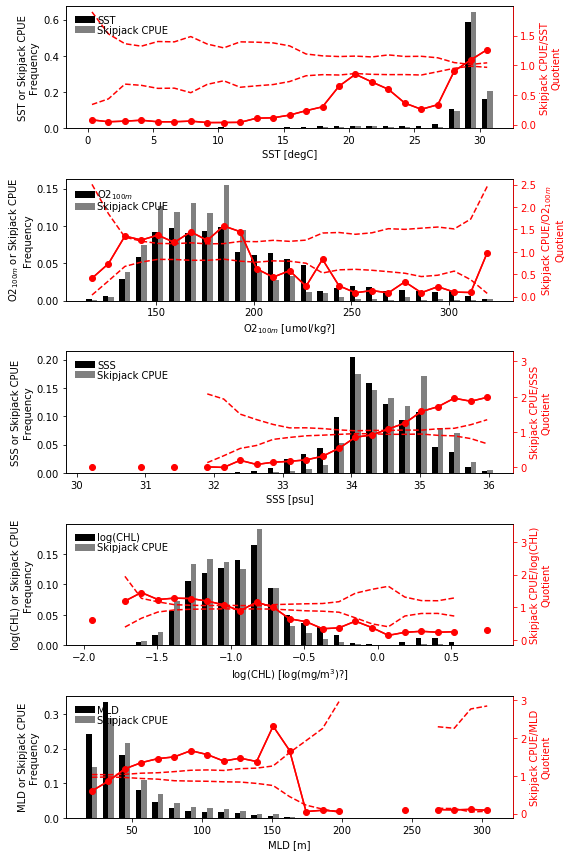

In [118]:
plotbarorhist='bar'; plotlegend=1;
plotqlimsreplaceT=1; plotqlimsreplaceF=0
nrows=5; ncols=1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,12))
isp = 0 # subplot index
for yax in range(0,nrows):
    for xax in range(0,ncols):
        ivunits = ivunitsall[isp]
        ivnicename = ivnicenamesall[isp]; dvnicename = dvnicenamesall[isp]
        iv = ivall[isp]
        binedges = binedgesall[isp]; bincenters = bincentersall[isp]
        ivcounts = ivcountsall[isp]; dvcounts = dvcountsall[isp]
        dvquot = dvquotall[isp]
        qlimsreplaceT = qlimsreplaceTall[isp]; qlimsreplaceF = qlimsreplaceFall[isp]
        if ncols>1 and nrows>1:
            ax = axes[yax][xax]
        elif ncols==1 and nrows>1:
            ax = axes[yax] 
        elif ncols>1 and nrows==1:
            ax = axes[xax] 
        exec(open("plot_qa.py").read())
        isp = isp+1
fig.tight_layout()
#fig.savefig(figpath + 'question3b_skjcpue_quotientanalysis.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

### BET CPUE x SST

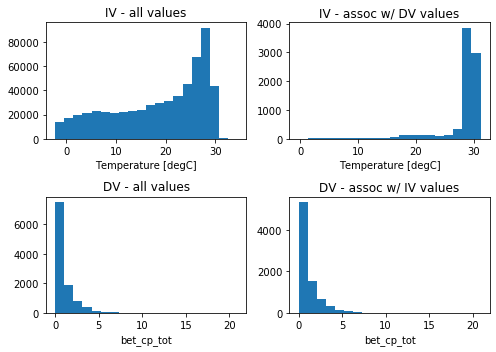

In [184]:
ivfull = sst; dvfull = bet_cp_tot
ivname = 'sst'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_sstbetcp, binedges_sstbetcp, bincenters_sstbetcp, ivcounts_sstbetcp, \
    dvcounts_sstbetcp, dvquot_sstbetcp, qlimsreplaceT_sstbetcp, qlimsreplaceF_sstbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x O2100

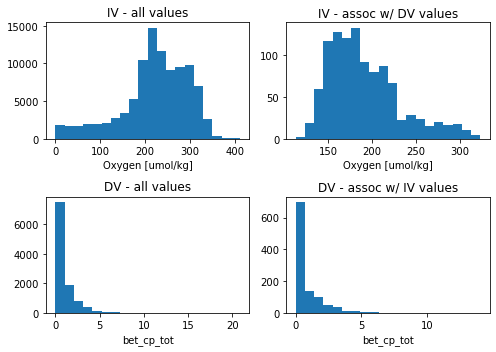

In [120]:
ivfull = o2100; dvfull = bet_cp_tot
ivname = 'o2100'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_o2100betcp, binedges_o2100betcp, bincenters_o2100betcp, ivcounts_o2100betcp, \
    dvcounts_o2100betcp, dvquot_o2100betcp, qlimsreplaceT_o2100betcp, qlimsreplaceF_o2100betcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x SSS 

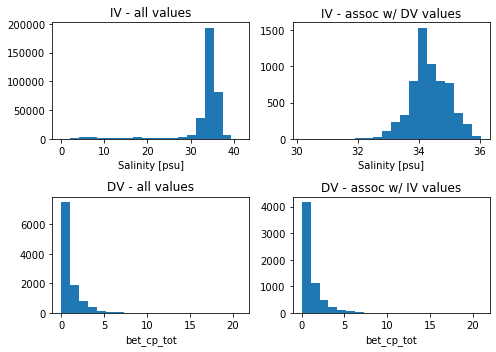

In [121]:
ivfull = sss; dvfull = bet_cp_tot
ivname = 'sss'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_sssbetcp, binedges_sssbetcp, bincenters_sssbetcp, ivcounts_sssbetcp, \
    dvcounts_sssbetcp, dvquot_sssbetcp, qlimsreplaceT_sssbetcp, qlimsreplaceF_sssbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x LOGCHL

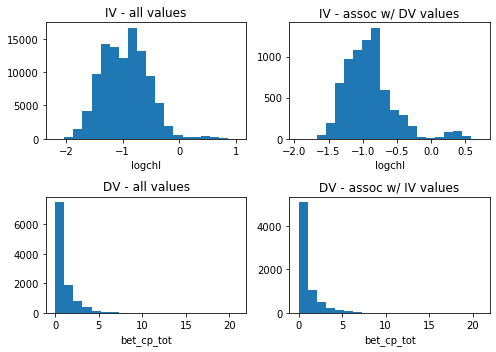

In [122]:
ivfull = logchl; dvfull = bet_cp_tot
ivname = 'logchl'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_logchlbetcp, binedges_logchlbetcp, bincenters_logchlbetcp, ivcounts_logchlbetcp, \
    dvcounts_logchlbetcp, dvquot_logchlbetcp, qlimsreplaceT_logchlbetcp, qlimsreplaceF_logchlbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE x MLD

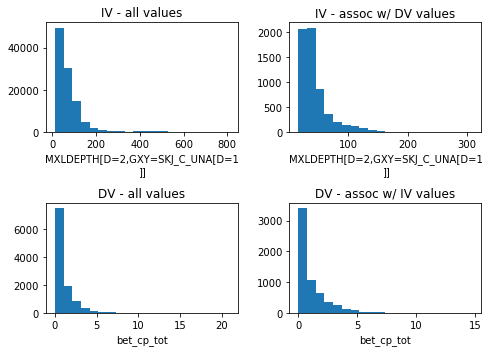

In [123]:
ivfull = mld; dvfull = bet_cp_tot
ivname = 'mld'; dvname = 'bet_cp_tot'
nruns = 399; nbins = 25
iv_mldbetcp, binedges_mldbetcp, bincenters_mldbetcp, ivcounts_mldbetcp, \
    dvcounts_mldbetcp, dvquot_mldbetcp, qlimsreplaceT_mldbetcp, qlimsreplaceF_mldbetcp \
    = qafull(ivfull,dvfull,ivname,dvname,nbins,nruns)

### BET CPUE quotient analysis plot

In [124]:
ivunitsall = ['degC','umol/kg?','psu','log(mg/m$^3$)?','m']
ivnicenamesall = ['SST','O$2_{100m}$','SSS','log(CHL)','MLD']
dvnicenamesall = ['Bigeye CPUE','Bigeye CPUE','Bigeye CPUE','Bigeye CPUE','Bigeye CPUE']
ivall = [iv_sstbetcp, iv_o2100betcp, iv_sssbetcp, iv_logchlbetcp, iv_mldbetcp]
binedgesall = [binedges_sstbetcp, binedges_o2100betcp, binedges_sssbetcp, binedges_logchlbetcp, binedges_mldbetcp]
bincentersall = [bincenters_sstbetcp, bincenters_o2100betcp, bincenters_sssbetcp, bincenters_logchlbetcp, bincenters_mldbetcp]
ivcountsall = [ivcounts_sstbetcp, ivcounts_o2100betcp, ivcounts_sssbetcp, ivcounts_logchlbetcp, ivcounts_mldbetcp]
dvcountsall = [dvcounts_sstbetcp, dvcounts_o2100betcp, dvcounts_sssbetcp, dvcounts_logchlbetcp, dvcounts_mldbetcp]
dvquotall = [dvquot_sstbetcp, dvquot_o2100betcp, dvquot_sssbetcp, dvquot_logchlbetcp, dvquot_mldbetcp]
qlimsreplaceTall = [qlimsreplaceT_sstbetcp, qlimsreplaceT_o2100betcp, qlimsreplaceT_sssbetcp, qlimsreplaceT_logchlbetcp, qlimsreplaceT_mldbetcp]
qlimsreplaceFall = [qlimsreplaceF_sstbetcp, qlimsreplaceF_o2100betcp, qlimsreplaceF_sssbetcp, qlimsreplaceF_logchlbetcp, qlimsreplaceF_mldbetcp]

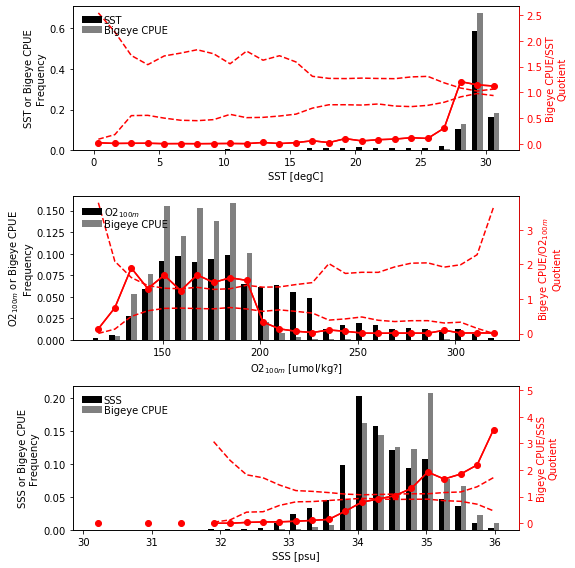

In [125]:
plotbarorhist='bar'; plotlegend=1;
plotqlimsreplaceT=1; plotqlimsreplaceF=0
nrows=3; ncols=1
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))
isp = 0 # subplot index
for yax in range(0,nrows):
    for xax in range(0,ncols):
        ivunits = ivunitsall[isp]
        ivnicename = ivnicenamesall[isp]; dvnicename = dvnicenamesall[isp]
        iv = ivall[isp]
        binedges = binedgesall[isp]; bincenters = bincentersall[isp]
        ivcounts = ivcountsall[isp]; dvcounts = dvcountsall[isp]
        dvquot = dvquotall[isp]
        qlimsreplaceT = qlimsreplaceTall[isp]; qlimsreplaceF = qlimsreplaceFall[isp]
        if ncols>1 and nrows>1:
            ax = axes[yax][xax]
        elif ncols==1 and nrows>1:
            ax = axes[yax] 
        elif ncols>1 and nrows==1:
            ax = axes[xax] 
        exec(open("plot_qa.py").read())
        isp = isp+1
fig.tight_layout()
fig.savefig(figpath + 'question3a_betcpue_quotientanalysis.png', bbox_inches='tight', pad_inches = 0, dpi = 200)

In [254]:
# CONTINUE HERE WITH 3c!!!!!

In [216]:
def defineATP(row):
    if row['quot']<row['2pt5p']:
        return -1 # avoidance
    if row['quot']>=row['2pt5p'] and row['quot']<=row['97pt5p']:
        return 0 # tolerance
    if row['quot']>row['97pt5p']:
        return 1 # preference

In [279]:
test = pd.concat([qlimsreplaceT_sstbetcp.transpose(),dvquot_sstbetcp], axis=1)
test = test.rename(columns={0:'quot', 0.025:'2pt5p', 0.975:'97pt5p'})
test['ATP'] = test.apply(defineATP, axis=1)
test.reset_index(inplace=True)
test = pd.concat([test,pd.Series(bincenters_sstbetcp)], axis=1)
test = test.rename(columns={0:'bincenters'})
#test

In [294]:
test1 = pd.concat([qlimsreplaceT_sstskjcp.transpose(),dvquot_sstskjcp], axis=1)
test1 = test1.rename(columns={0:'quot', 0.025:'2pt5p', 0.975:'97pt5p'})
test1['ATP'] = test1.apply(defineATP, axis=1)
test1.reset_index(inplace=True)
test1 = pd.concat([test1,pd.Series(bincenters_sstskjcp)], axis=1)
test1 = test1.rename(columns={0:'bincenters'})
#test1

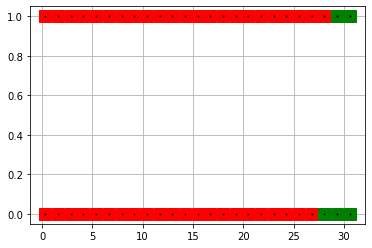

In [302]:
avoidnow = test['bincenters'][test['ATP']==-1] 
tolnow = test['bincenters'][test['ATP']==0] 
prefnow = test['bincenters'][test['ATP']==1] 
plt.plot(avoidnow,np.zeros(len(avoidnow)),'s',markersize=12,color='red')
plt.plot(avoidnow,np.zeros(len(avoidnow)),'o',markersize=1,color='black')
plt.plot(tolnow,np.zeros(len(tolnow)),'s',markersize=12,color='yellow')
plt.plot(tolnow,np.zeros(len(tolnow)),'o',markersize=1,color='black')
plt.plot(prefnow,np.zeros(len(prefnow)),'s',markersize=12,color='green')
plt.plot(prefnow,np.zeros(len(prefnow)),'o',markersize=1,color='black')

avoidnow = test1['bincenters'][test1['ATP']==-1] 
tolnow = test1['bincenters'][test1['ATP']==0] 
prefnow = test1['bincenters'][test1['ATP']==1] 
plt.plot(avoidnow,np.ones(len(avoidnow)),'s',markersize=12,color='red')
plt.plot(avoidnow,np.ones(len(avoidnow)),'o',markersize=1,color='black')
plt.plot(tolnow,np.ones(len(tolnow)),'s',markersize=12,color='yellow')
plt.plot(tolnow,np.ones(len(tolnow)),'o',markersize=1,color='black')
plt.plot(prefnow,np.ones(len(prefnow)),'s',markersize=12,color='green')
plt.plot(prefnow,np.ones(len(prefnow)),'o',markersize=1,color='black')
plt.grid('both')